# 📘 IDECEP – Uses with Trained Artifacts

Melhorias nesta versão:
- Alvo em **`dln_y`/`dln_pib_real`** (mesma escala do modelo).
- Choques reconhecem automaticamente **`dln_x`**, **`dln_receita_real`** ou **`dln_despesa_real`** (+0.01 ≈ +1 p.p.).
- Predição robusta p/ **statsmodels**/**sklearn** e alinhamento do tamanho de amostra.

In [1]:
# === Project root autodetect ===
from pathlib import Path

def find_project_root(start: Path | None = None) -> Path:
    start = Path(start or Path.cwd()).resolve()
    markers = {"configs", "scripts", "src", "requirements.txt", "README.md", ".git"}
    for p in [start, *start.parents]:
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
print("ROOT =", ROOT)

ROOT = /home/kelven/Projetos/idecep


In [2]:
# === Imports & setup ===
import pickle, warnings, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = ROOT / "outputs" / "idecep_uses"
OUT_DIR.mkdir(parents=True, exist_ok=True)

PATH_MODEL = ROOT / "outputs" / "idecep" / "best_model.pkl"
PATH_PROC  = ROOT / "outputs" / "idecep" / "idecep_processed.csv"
VAL_DIR    = ROOT / "outputs" / "idecep_validation"

print("MODEL :", PATH_MODEL.exists(), PATH_MODEL)
print("PROC  :", PATH_PROC.exists(), PATH_PROC)
print("VALDIR:", VAL_DIR.exists(), VAL_DIR)

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

MODEL : True /home/kelven/Projetos/idecep/outputs/idecep/best_model.pkl
PROC  : True /home/kelven/Projetos/idecep/outputs/idecep/idecep_processed.csv
VALDIR: True /home/kelven/Projetos/idecep/outputs/idecep_validation


In [3]:
# === Load artifacts ===
assert PATH_MODEL.exists(), "best_model.pkl não encontrado em outputs/idecep/"
assert PATH_PROC.exists(),  "idecep_processed.csv não encontrado em outputs/idecep/"

with open(PATH_MODEL, "rb") as f:
    model = pickle.load(f)

dfp = pd.read_csv(PATH_PROC)
for c in ["date","Date","DATA","data"]:
    if c in dfp.columns:
        dfp = dfp.rename(columns={c:"date"})
        break
if "date" in dfp.columns:
    dfp["date"] = pd.to_datetime(dfp["date"], errors="coerce")

print("dfp shape:", dfp.shape)
display(dfp.head(3))

dfp shape: (176, 33)


,date,pib_nominal_brl,receita_pct_pib,despesa_pct_pib,divida_pct_pib,ipca_indice,selic_meta,cambio_usd,producao_industrial,receita_nominal_brl,...,idecep_log_ratio_clipped,idecep_gap_growth,pib_real_rebased_2008,receita_real_rebased_2008,idecep_gap2008,idecep_z2008,pre_2008,post_2008,post_2014,pandemia
0,1980-03-31,2.836682e+00,32.921,37.215,-0.69,4.072963,45.0,1.8003,72.4,9.338642e-01,...,NaN,NaN,4.834560e-11,4.242297e-11,NaN,NaN,1,0,0,0
1,1980-06-30,1.713318e+00,32.921,37.215,-0.69,4.291778,45.0,1.8003,72.4,5.640413e-01,...,100.0,-1.043610e-12,2.771133e-11,2.431652e-11,-1.392664e-12,-0.099578,1,0,0,0
2,1980-09-30,2.484662e-11,32.921,37.215,-0.69,4.729407,45.0,1.8003,72.4,8.179757e-12,...,100.0,-2.486900e-12,3.646846e-22,3.200085e-22,-3.410605e-12,-0.266823,1,0,0,0


In [4]:
# === Feature discovery & target selection ===
TARGET_CANDIDATES = [
    "dln_y","dln_pib_real","dln_PIB","dln_pib_real_brl",
    "y","target","pib_real_brl"
]
date_cols = {"date","period","time"}

def find_target_column(df: pd.DataFrame):
    name = getattr(model, "target_name", None)
    if name and name in df.columns:
        return name
    for c in TARGET_CANDIDATES:
        if c in df.columns:
            return c
    return "y" if "y" in df.columns else None

def get_feature_names_from_model(df: pd.DataFrame):
    if hasattr(model, "feature_names_in_"):
        return [c for c in model.feature_names_in_ if c in df.columns]
    if hasattr(model, "model") and hasattr(model.model, "exog_names"):
        names = [n for n in model.model.exog_names if n != "const"]
        return [c for c in names if c in df.columns]
    return None

y_col = find_target_column(dfp)
feat_cols = get_feature_names_from_model(dfp)
if feat_cols is None:
    numeric_cols = dfp.select_dtypes(include=[np.number]).columns.tolist()
    blacklist = set([y_col] if y_col else []) | {"date"}
    feat_cols = [c for c in numeric_cols if c not in blacklist]

print("y_col  =", y_col)
print("n_feats=", len(feat_cols))
print(sorted(feat_cols)[:12], "...")

X = dfp[feat_cols].copy()
y = (dfp[y_col] if (y_col and y_col in dfp.columns) else None)

y_col  = dln_pib_real
n_feats= 5
['dln_despesa_real', 'dln_divida_real', 'dln_ipca', 'dln_prod_ind', 'dln_receita_real'] ...


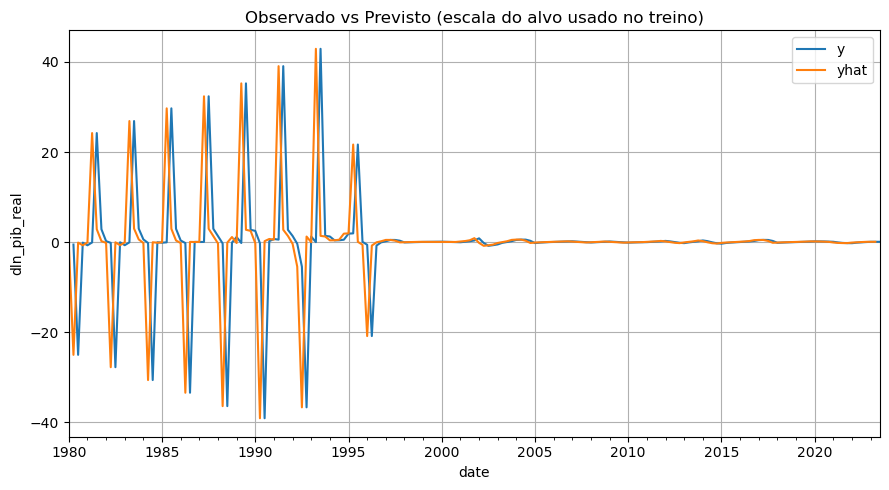

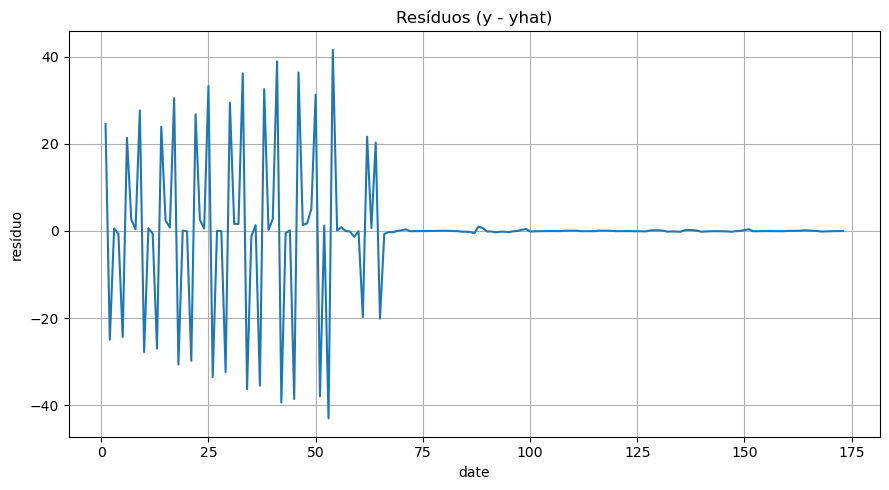

,date,yhat,y
172,2023-03-31,0.058128,0.055170
173,2023-06-30,0.056401,0.063698
174,2023-09-30,NaN,0.057836


In [9]:
# === Predict (robusto p/ statsmodels / sklearn) ===
def _predict(m, X):
    n = len(X)
    mod_name = type(m).__module__
    X = X.copy()
    if not isinstance(X.index, pd.RangeIndex):
        X.index = pd.RangeIndex(n)

    if "statsmodels" in mod_name:
        n_train = None
        if hasattr(m, "model") and hasattr(m.model, "exog") and m.model.exog is not None:
            n_train = m.model.exog.shape[0]
        if n_train is None and hasattr(m, "nobs"):
            n_train = int(getattr(m, "nobs"))
        if n_train is None:
            n_train = n

        sig = inspect.signature(m.predict)
        params = sig.parameters

        if "exog" in params:
            X_in = X.iloc[:n_train]
            try:
                yhat = m.predict(exog=X_in, start=0, end=n_train-1, dynamic=False)
            except TypeError:
                yhat = m.predict(exog=X_in, start=0, end=n_train-1)
            yhat = pd.Series(np.asarray(yhat), index=X_in.index, name="yhat")
            return yhat, n_train
        else:
            try:
                yhat = m.predict(start=0, end=n_train-1, dynamic=False)
            except TypeError:
                yhat = m.predict(start=0, end=n_train-1)
            yhat = pd.Series(np.asarray(yhat), index=pd.RangeIndex(n_train), name="yhat")
            return yhat, n_train

    # sklearn-like
    if hasattr(m, "predict"):
        yhat = m.predict(X)
        return pd.Series(np.asarray(yhat), index=X.index, name="yhat"), n

    raise RuntimeError("Modelo não possui método predict compatível.")

yhat, n_used = _predict(model, X)

dates = dfp.get("date", pd.RangeIndex(len(X)))
dates = dates.iloc[:n_used].reset_index(drop=True)

df_eval = pd.DataFrame({"date": dates, "yhat": yhat.values})
if y is not None:
    df_eval["y"] = y.iloc[:n_used].values

ax = df_eval.plot(x="date", y=["y","yhat"] if "y" in df_eval.columns else ["yhat"])
ax.set_title("Observado vs Previsto (escala do alvo usado no treino)")
ax.set_xlabel("date"); ax.set_ylabel(y_col or "y")
plt.tight_layout(); plt.savefig(OUT_DIR / "observado_vs_previsto.png", dpi=140); plt.show()

if "y" in df_eval.columns:
    resid = df_eval["y"] - df_eval["yhat"]
    ax = resid.plot()
    ax.set_title("Resíduos (y - yhat)")
    ax.set_xlabel("date"); ax.set_ylabel("resíduo")
    plt.tight_layout(); plt.savefig(OUT_DIR / "residuos.png", dpi=140); plt.show()

display(df_eval.tail(3))

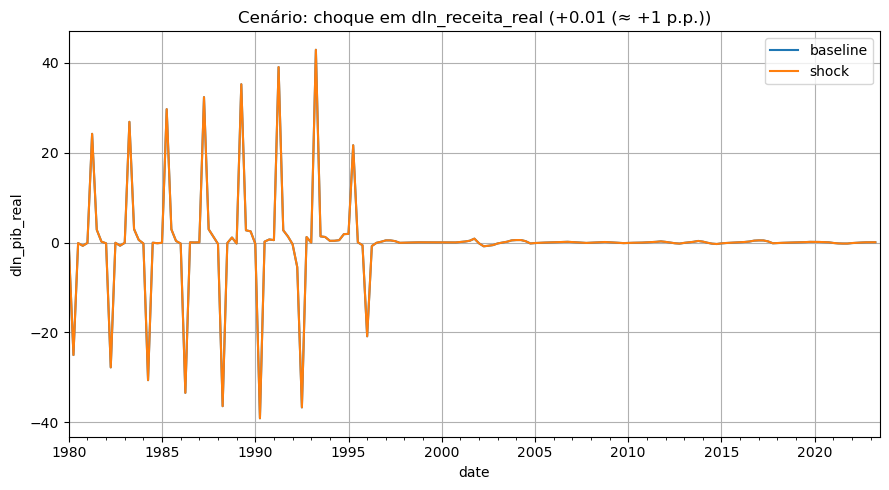

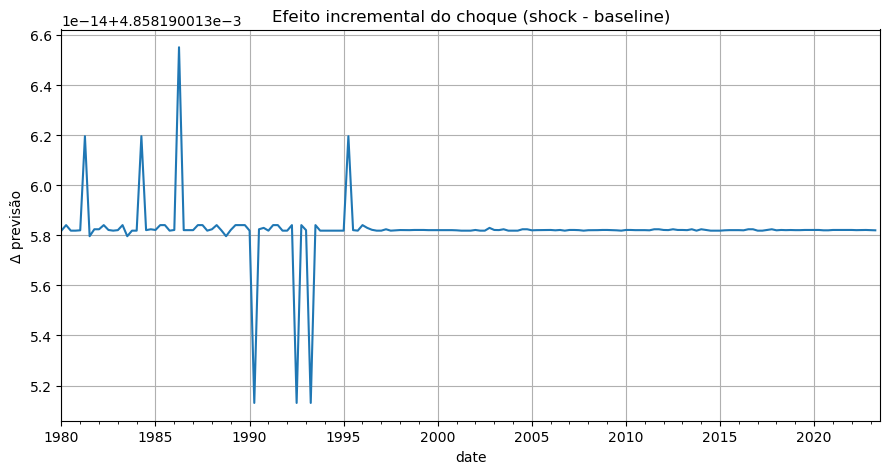

In [6]:
# === Cenários contrafactuais: dln_x / dln_receita_real / dln_despesa_real ===
import warnings

def simulate_shock(df_base: pd.DataFrame, model, deltas: dict, rows=None, n_used=None):
    Xb = df_base.copy()
    for col, d in deltas.items():
        if col in Xb.columns:
            Xb.loc[rows if rows is not None else slice(None), col] = Xb[col] + d
        else:
            warnings.warn(f"Coluna {col} não está em feat_cols; ignorando choque.")
    yh_base, n_b = _predict(model, df_base)
    yh_new,  n_n = _predict(model, Xb)
    n_final = n_used if n_used is not None else min(n_b, n_n)
    yh_base = yh_base.iloc[:n_final]
    yh_new  = yh_new.iloc[:n_final]
    return yh_new, (yh_new - yh_base), n_final

# seleção automática da coluna-alvo do choque (ordem de preferência)
shock_key = None
for cand in ["dln_x", "dln_receita_real", "dln_despesa_real", "receita_pct_pib", "despesa_pct_pib"]:
    if cand in X.columns:
        shock_key = cand
        break

if shock_key is not None:
    # magnitude: +0.01 (~ +1 p.p. em Δln). Para p.p. (% do PIB), +1.0 é 1 ponto percentual.
    delta_val = 0.01 if shock_key.startswith("dln_") else 1.0
    yhat_new, delta, n_cf = simulate_shock(X, model, {shock_key: delta_val}, n_used=n_used)
    df_cf = pd.DataFrame({
        "date": df_eval["date"].iloc[:n_cf].reset_index(drop=True),
        "baseline": df_eval["yhat"].iloc[:n_cf].values,
        "shock": yhat_new.values,
        "delta": delta.values
    })
    ax = df_cf.plot(x="date", y=["baseline","shock"])
    ax.set_title(f"Cenário: choque em {shock_key} (+{delta_val} {'(≈ +1 p.p.)' if shock_key.startswith('dln_') else 'p.p.'})")
    ax.set_xlabel("date"); ax.set_ylabel(y_col or "y")
    plt.tight_layout(); plt.savefig(OUT_DIR / "cenario_shock.png", dpi=140); plt.show()

    ax = df_cf.plot(x="date", y="delta", legend=False)
    ax.set_title("Efeito incremental do choque (shock - baseline)")
    ax.set_xlabel("date"); ax.set_ylabel("Δ previsão")
    plt.tight_layout(); plt.savefig(OUT_DIR / "cenario_delta.png", dpi=140); plt.show()
else:
    print("Nenhuma coluna encontrada para choque (dln_x / dln_receita_real / dln_despesa_real / pct_pib).")

In [7]:
# === Diagnósticos do pipeline (se existirem) ===
VAL_DIR = ROOT / "outputs" / "idecep_validation"
if VAL_DIR.exists():
    for name in ["idecep_ecm_diagnostics.csv","idecep_gate_report.csv","idecep_rolling_logdiff.csv","idecep_stationarity_checks.csv"]:
        p = VAL_DIR / name
        if p.exists():
            dfv = pd.read_csv(p)
            print("\n##", name, "->", p)
            display(dfv.head(5))
else:
    print("Diretório de validação não encontrado:", VAL_DIR)


## idecep_ecm_diagnostics.csv -> /home/kelven/Projetos/idecep/outputs/idecep_validation/idecep_ecm_diagnostics.csv


,ADF p,KPSS p,Ljung-Box p (12),Ljung-Box p (24),BG p (12),ARCH LM p,Jarque-Bera p,Durbin-Watson
0,0.011193,0.1,6.373997e-19,1.030920e-26,1.495980e-10,5.864747e-08,0.0,2.251359



## idecep_gate_report.csv -> /home/kelven/Projetos/idecep/outputs/idecep_validation/idecep_gate_report.csv


,Estacionariedade (dln),ECT significativo (<0)
0,True,True



## idecep_rolling_logdiff.csv -> /home/kelven/Projetos/idecep/outputs/idecep_validation/idecep_rolling_logdiff.csv


,date,y_true,y_pred
0,1989-06-30,0.000000,-0.002380
1,1989-09-30,10.460803,10.513413
2,1989-12-31,2.726796,2.744206
3,1990-03-31,2.484594,2.514856
4,1990-06-30,-0.256876,-0.272900



## idecep_stationarity_checks.csv -> /home/kelven/Projetos/idecep/outputs/idecep_validation/idecep_stationarity_checks.csv


,series,ADF p,KPSS p
0,pib_real_rebased_2008 (nível),0.000184,0.10
1,receita_real_rebased_2008 (nível),0.000184,0.10
2,ln_y (nível),0.395195,0.01
3,ln_x (nível),0.397295,0.01
4,dln_y,0.000341,0.10


In [10]:
from pathlib import Path

# Salvar os DataFrames dfp, df_eval e df_cf em um diretório x

DIR_X = ROOT / "outputs" / "idecep_uses"
DIR_X.mkdir(parents=True, exist_ok=True)

dfp.to_csv(DIR_X / "dfp.csv", index=False)
df_eval.to_csv(DIR_X / "df_eval.csv", index=False)
df_cf.to_csv(DIR_X / "df_cf.csv", index=False)